In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import math
from datetime import timezone, datetime
import json

from tqdm import tqdm

import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

from dtreeviz import trees
from dtreeviz.models.lightgbm_decision_tree import ShadowLightGBMTree

import sys
sys.path.append('..')
from cpcv_util import *
from optuna_util import *

In [2]:
options = {
    'read_timescaledb': False,
    'optimize_atr': False,
    'train_with_optuna': False,
    'svg_output': False
}

In [3]:
from timescaledb_util import *

# TimescaleDB用のユーティリティライブラリの設定
_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
if options['read_timescaledb'] == True:
    print('Read from timescaledb')
    _dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

    # 全区間のドルバーの読み込みと保存 (mplfinanceでの表示のためにカラム名を変更している)
    df = _dbutil.load_dollarbars('ftx', 'BTC-PERP', 5000000, '2021-01-01 00:00:00.000+00', '2023-01-01 00:00:00.000+00')
    df.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum', 'dollar_buy_cumsum', 'dollar_sell_cumsum']
    df['fee'] = 0.02 / 100
    df.to_pickle('df_ohlcv.pkl')
else:
    # 保存しておいたドルバーを読み込み
    print('Read from df_ohlcv.pkl')
    df = pd.read_pickle('df_ohlcv.pkl')

display(df)

Read from df_ohlcv.pkl


,Datetime,Open,High,Low,Close,dollar_volume,dollar_buy_volume,dollar_sell_volume,dollar_liquidation_buy_volume,dollar_liquidation_sell_volume,dollar_cumsum,dollar_buy_cumsum,dollar_sell_cumsum,fee
0,2021-01-01 00:00:36.894000+00:00,29000.0,29029.5,28942.0,28986.5,4.959114e+06,2.564786e+06,2.394328e+06,15531.15400,0.0000,1.923799e+11,9.610236e+10,9.627756e+10,0.0002
1,2021-01-01 00:02:41.379000+00:00,28986.5,29056.0,28979.5,29024.0,5.079592e+06,3.454632e+06,1.624960e+06,206.27575,9175.8848,1.923850e+11,9.610582e+10,9.627918e+10,0.0002
2,2021-01-01 00:08:30.311000+00:00,29024.0,29035.5,28920.0,28942.0,4.998602e+06,8.668237e+05,4.131778e+06,0.00000,0.0000,1.923900e+11,9.610668e+10,9.628331e+10,0.0002
3,2021-01-01 00:10:12.622000+00:00,28942.0,28961.5,28876.0,28907.0,4.991658e+06,2.499264e+06,2.492394e+06,0.00000,0.0000,1.923950e+11,9.610918e+10,9.628581e+10,0.0002
4,2021-01-01 00:13:09.482000+00:00,28907.0,28911.0,28815.5,28850.0,4.896911e+06,1.380208e+06,3.516703e+06,0.00000,6309.5344,1.923999e+11,9.611056e+10,9.628932e+10,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289625,2022-02-10 14:08:30.175000+00:00,43343.0,43382.0,43287.0,43290.0,4.870829e+06,2.014914e+06,2.855915e+06,0.00000,869601.0551,1.641145e+12,8.135513e+11,8.275937e+11,0.0002
289626,2022-02-10 14:09:05.269000+00:00,43282.0,43368.0,43262.0,43328.0,4.995557e+06,3.379773e+06,1.615784e+06,0.00000,0.0000,1.641150e+12,8.135547e+11,8.275953e+11,0.0002
289627,2022-02-10 14:09:32.103000+00:00,43328.0,43400.0,43316.0,43393.0,5.018838e+06,2.991151e+06,2.027687e+06,0.00000,0.0000,1.641155e+12,8.135577e+11,8.275973e+11,0.0002
289628,2022-02-10 14:09:45.133000+00:00,43395.0,43419.0,43372.0,43397.0,4.980746e+06,2.915359e+06,2.065386e+06,0.00000,0.0000,1.641160e+12,8.135606e+11,8.275994e+11,0.0002


In [4]:
# Richmanbtcさんのチュートリアルの関数をカスタムした関数群

def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
    
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
    
    hilo = (high + low) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)
    
    df['CLOSE_LOG'] = np.log1p(df['Close'])
    df['CLOSE_LOGDIFF'] = df['CLOSE_LOG'].diff()
    df['CLOSE_LOGDIFF_1'] = df['CLOSE_LOGDIFF'].shift(-1)
        
    # ドルバー由来の特徴量を追加
    df['TIME'] = df['Datetime']
    df['DELTA_TIME_0'] = df['TIME'].diff()
    df['DELTA_TIME_0'] = df['DELTA_TIME_0'].view(int) / 1_000_000_000 # 単位は秒
    df['DELTA_TIME_1'] = df['DELTA_TIME_0'].shift(-1)
    df['DELTA_TIME_-1'] = df['DELTA_TIME_0'].shift(1)
    df['DELTA_TIME_-2'] = df['DELTA_TIME_0'].shift(2)
    df['DELTA_TIME_-3'] = df['DELTA_TIME_0'].shift(3)
    df['DELTA_TIME_-4'] = df['DELTA_TIME_0'].shift(4)
    
    df['DELTA_TIME_LOG_0'] = np.log1p(df['DELTA_TIME_0'] * 100)
    df['DELTA_TIME_LOGDIFF_0'] = df['DELTA_TIME_LOG_0'].diff()
    df['DELTA_TIME_LOGDIFF_1'] = df['DELTA_TIME_LOGDIFF_0'].shift(-1)
    df['DELTA_TIME_LOGDIFF_-1'] = df['DELTA_TIME_LOGDIFF_0'].shift(1)
    df['DELTA_TIME_LOGDIFF_-2'] = df['DELTA_TIME_LOGDIFF_0'].shift(2)
    df['DELTA_TIME_LOGDIFF_-3'] = df['DELTA_TIME_LOGDIFF_0'].shift(3)
    df['DELTA_TIME_LOGDIFF_-4'] = df['DELTA_TIME_LOGDIFF_0'].shift(4)
    
    df['BUY_RATIO_0'] = df['dollar_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['BUY_RATIO_1'] = df['BUY_RATIO_0'].shift(-1)
    df['BUY_RATIO_-1'] = df['BUY_RATIO_0'].shift(1)
    df['BUY_RATIO_-2'] = df['BUY_RATIO_0'].shift(2)
    df['BUY_RATIO_-3'] = df['BUY_RATIO_0'].shift(3)
    df['BUY_RATIO_-4'] = df['BUY_RATIO_0'].shift(4)
    
    df['BUY_RATIO_LOG_0'] = np.log1p(df['BUY_RATIO_0'] * 100)
    df['BUY_RATIO_LOGDIFF_0'] = df['BUY_RATIO_LOG_0'].diff()
    df['BUY_RATIO_LOGDIFF_1'] = df['BUY_RATIO_LOGDIFF_0'].shift(-1)
    df['BUY_RATIO_LOGDIFF_-1'] = df['BUY_RATIO_LOGDIFF_0'].shift(1)
    df['BUY_RATIO_LOGDIFF_-2'] = df['BUY_RATIO_LOGDIFF_0'].shift(2)
    df['BUY_RATIO_LOGDIFF_-3'] = df['BUY_RATIO_LOGDIFF_0'].shift(3)
    df['BUY_RATIO_LOGDIFF_-4'] = df['BUY_RATIO_LOGDIFF_0'].shift(4)
    
    df['LIQUIDATION_BUY_RATIO_0'] = df['dollar_liquidation_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_BUY_RATIO_-1'] = df['LIQUIDATION_BUY_RATIO_0'].shift(1)
    df['LIQUIDATION_BUY_RATIO_-2'] = df['LIQUIDATION_BUY_RATIO_0'].shift(2)
    df['LIQUIDATION_BUY_RATIO_-3'] = df['LIQUIDATION_BUY_RATIO_0'].shift(3)
    df['LIQUIDATION_BUY_RATIO_-4'] = df['LIQUIDATION_BUY_RATIO_0'].shift(4)

    df['LIQUIDATION_SELL_RATIO_0'] = df['dollar_liquidation_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_BUY_RATIO_-1'] = df['LIQUIDATION_BUY_RATIO_0'].shift(1)
    df['LIQUIDATION_BUY_RATIO_-2'] = df['LIQUIDATION_BUY_RATIO_0'].shift(2)
    df['LIQUIDATION_BUY_RATIO_-3'] = df['LIQUIDATION_BUY_RATIO_0'].shift(3)
    df['LIQUIDATION_BUY_RATIO_-4'] = df['LIQUIDATION_BUY_RATIO_0'].shift(4)
    
    df.dropna(inplace = True)
    df = df.reset_index(drop = True)
    
    return df

In [5]:
from sklearn.metrics import mean_squared_error

# 真値と予測値を比較して表示するためのユーティリティ関数
def display_true_vs_pred(series_true, series_pred, subtitle):
    df = pd.DataFrame({'true': series_true, 'pred': series_pred}).dropna()
    corr = np.corrcoef(df['true'], df['pred'])
    pred_std = df['pred'].std()
    pred_mean = df['pred'].mean()
    true_std = df['true'].std()
    true_mean = df['true'].mean()
    
    pred_max = pred_mean + 4*pred_std
    pred_min = pred_mean - 4*pred_std
    true_max = true_mean + 4*true_std
    true_min = true_mean - 4*true_std
    
    fig, ax = plt.subplots(2, 2, sharex='col', sharey = 'row',
                           gridspec_kw={'width_ratios': [2, 0.5], 'height_ratios': [2, 0.5]}, figsize=(6, 6))
    
    # 予測値のレンジごとに真値の平均をプロットして比例関係があることを確認する
    pred_sections = []
    true_means = []
    for i in range(17):
        _df = df[(df['pred'] >= pred_min + 0.5 * pred_std * i) & (df['pred'] < pred_min + 0.5 * pred_std * (i + 1))]
        pred_sections.append(pred_min + 0.5 * pred_std * i)
        true_means.append(_df['true'].mean())

    # 散布図をプロットする
    ax[0, 0].scatter(df['pred'], df['true'], s = 1)
    ax[0, 0].step(pred_sections, true_means, 'red', where='post')
    ax[0, 0].set_title(subtitle + f' (IC={corr[0][1]:0.4f})')
    ax[0, 0].set_xlabel("prediction")
    ax[0, 0].set_ylabel("truth")
    ax[0, 0].set_xlim([pred_min, pred_max])
    ax[0, 0].set_ylim([true_min, true_max])
    ax[0, 0].set_xticks([pred_mean, pred_mean - 2*pred_std, pred_mean - 4*pred_std, pred_mean + 2*pred_std, pred_mean + 4*pred_std])
    ax[0, 0].set_yticks([true_mean, true_mean - 2*true_std, true_mean - 4*true_std, true_mean + 2*true_std, true_mean + 4*true_std])
    ax[0, 0].grid(axis = 'both')
    ax[0, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    ax[0, 0].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    # 0と予測した値を表示するとヒストグラムがまともに見えないので除外している
    ax[1, 0].hist(df.loc[df['true'] != 0, 'pred'], bins=50, range=[pred_min, pred_max])
    ax[1, 0].grid(axis = 'both')
    ax[1, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[0, 1].hist(df.loc[df['true'] != 0, 'true'], bins=50, orientation='horizontal', range=[true_min, true_max])
    ax[0, 1].grid(axis = 'both')
    ax[0, 1].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[1, 1].remove()
    
    fig.show()

In [6]:
# 学習に利用しない特徴量はコメントアウトすること
features = sorted([
#    'BBANDS_upperband', 'BBANDS_middleband', 'BBANDS_lowerband',
    'BUY_RATIO_0', 'BUY_RATIO_-1', 'BUY_RATIO_-2', 'BUY_RATIO_-3', 'BUY_RATIO_-4',
    'BUY_RATIO_LOGDIFF_0', 'BUY_RATIO_LOGDIFF_-1', 'BUY_RATIO_LOGDIFF_-2', 'BUY_RATIO_LOGDIFF_-3', 'BUY_RATIO_LOGDIFF_-4',
#    'SELL_RATIO',
#    'SELL_RATIO_T-1', 'SELL_RATIO_T-2', 'SELL_RATIO_T-3', 'SELL_RATIO_T-4',
#    'LIQUIDATION_BUY_RATIO',
#    'LIQUIDATION_BUY_RATIO_DIFF_T-1', 'LIQUIDATION_BUY_RATIO_DIFF_T-2', 'LIQUIDATION_BUY_RATIO_DIFF_T-3', 'LIQUIDATION_BUY_RATIO_DIFF_T-4',
#    'LIQUIDATION_SELL_RATIO',
#    'LIQUIDATION_SELL_RATIO_DIFF_T-1', 'LIQUIDATION_SELL_RATIO_DIFF_T-2', 'LIQUIDATION_SELL_RATIO_DIFF_T-3', 'LIQUIDATION_SELL_RATIO_DIFF_T-4',
    'DELTA_TIME_0', 'DELTA_TIME_-1', 'DELTA_TIME_-2', 'DELTA_TIME_-3', 'DELTA_TIME_-4',
    'DELTA_TIME_LOGDIFF_0', 'DELTA_TIME_LOGDIFF_-1', 'DELTA_TIME_LOGDIFF_-2', 'DELTA_TIME_LOGDIFF_-3', 'DELTA_TIME_LOGDIFF_-4'
])

target = 'BUY_RATIO_LOGDIFF_1'

In [7]:
# 保存済みのデータフレームを読み込む
df = pd.read_pickle('df_ohlcv.pkl')

# トレーニングデータに特徴量を追加
df_train = df[(df['Datetime'] >= '2021-01-01 00:00:00+00') & (df['Datetime'] < '2022-01-01 00:00:00+00')].copy()
df_train = calc_features(df_train)

pd.set_option('max_columns', None)

lgb_util = LightGBMRegressionUtil()

# Optunaを使わないCPCVを使った学習を行う
folds = cpcv_split(df_train)

if options['train_with_optuna'] == True:
    use_optuna = True
else:
    use_optuna = False

lgb_util.train_cv(df_train[features], df_train[target], folds, use_optuna = use_optuna)

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


/tmp/ipykernel_2033370/1196386425.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['LIQUIDATION_SELL_RATIO_0'] = df['dollar_liquidation_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])


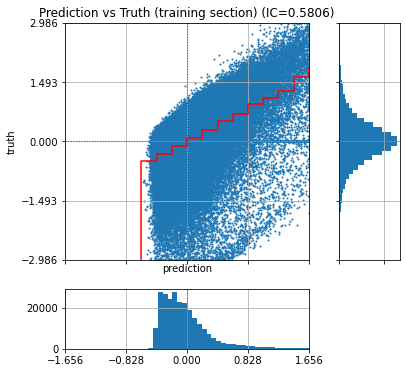

In [8]:
# トレーニング区間のデータに特徴量を追加
df_train = df[(df['Datetime'] >= '2021-01-01 00:00:00+00') & (df['Datetime'] < '2022-01-01 00:00:00+00')].reset_index().copy()
df_train = calc_features(df_train)

# 学習区間について予測を行い、学習したモデルの性能を確認する
df_train['y_pred'] = lgb_util.predict(df_train[features], folds, predict_training = True)

# 真値と予測値の関係を見る
display_true_vs_pred(df_train[target], df_train['y_pred'], 'Prediction vs Truth (training section)')

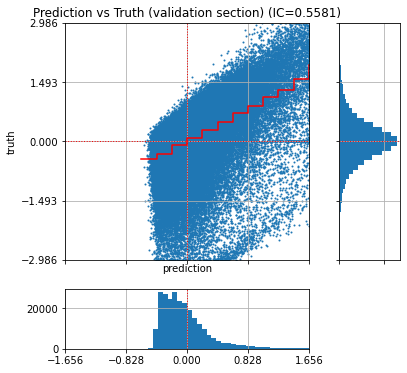

In [9]:
# バリデーション区間について予測を行い、学習したモデルの性能を確認する
df_train['y_pred'] = lgb_util.predict(df_train[features], folds)

# 真値と予測値の関係を見る
display_true_vs_pred(df_train[target], df_train['y_pred'], 'Prediction vs Truth (validation section)')

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2033370/1196386425.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['LIQUIDATION_SELL_RATIO_0'] = df['dollar_liquidation_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])


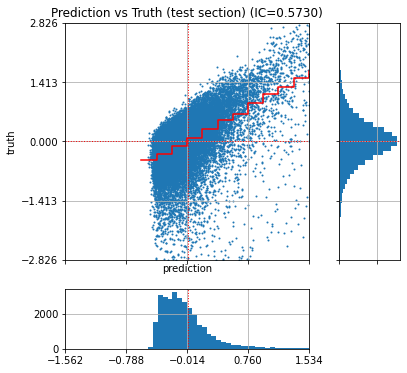

In [10]:
# テスト区間について予測を行い、学習したモデルの性能を確認する
df = pd.read_pickle('df_ohlcv.pkl')
df_test = df[(df['Datetime'] >= '2022-01-01 00:00:00+00') & (df['Datetime'] < '2023-01-01 00:00:00+00')].reset_index().copy()
df_test = calc_features(df_test)

df_test['y_pred'] = lgb_util.predict(df_test[features])

# 真値と予測値の関係を見る
display_true_vs_pred(df_test[target], df_test['y_pred'], 'Prediction vs Truth (test section)')

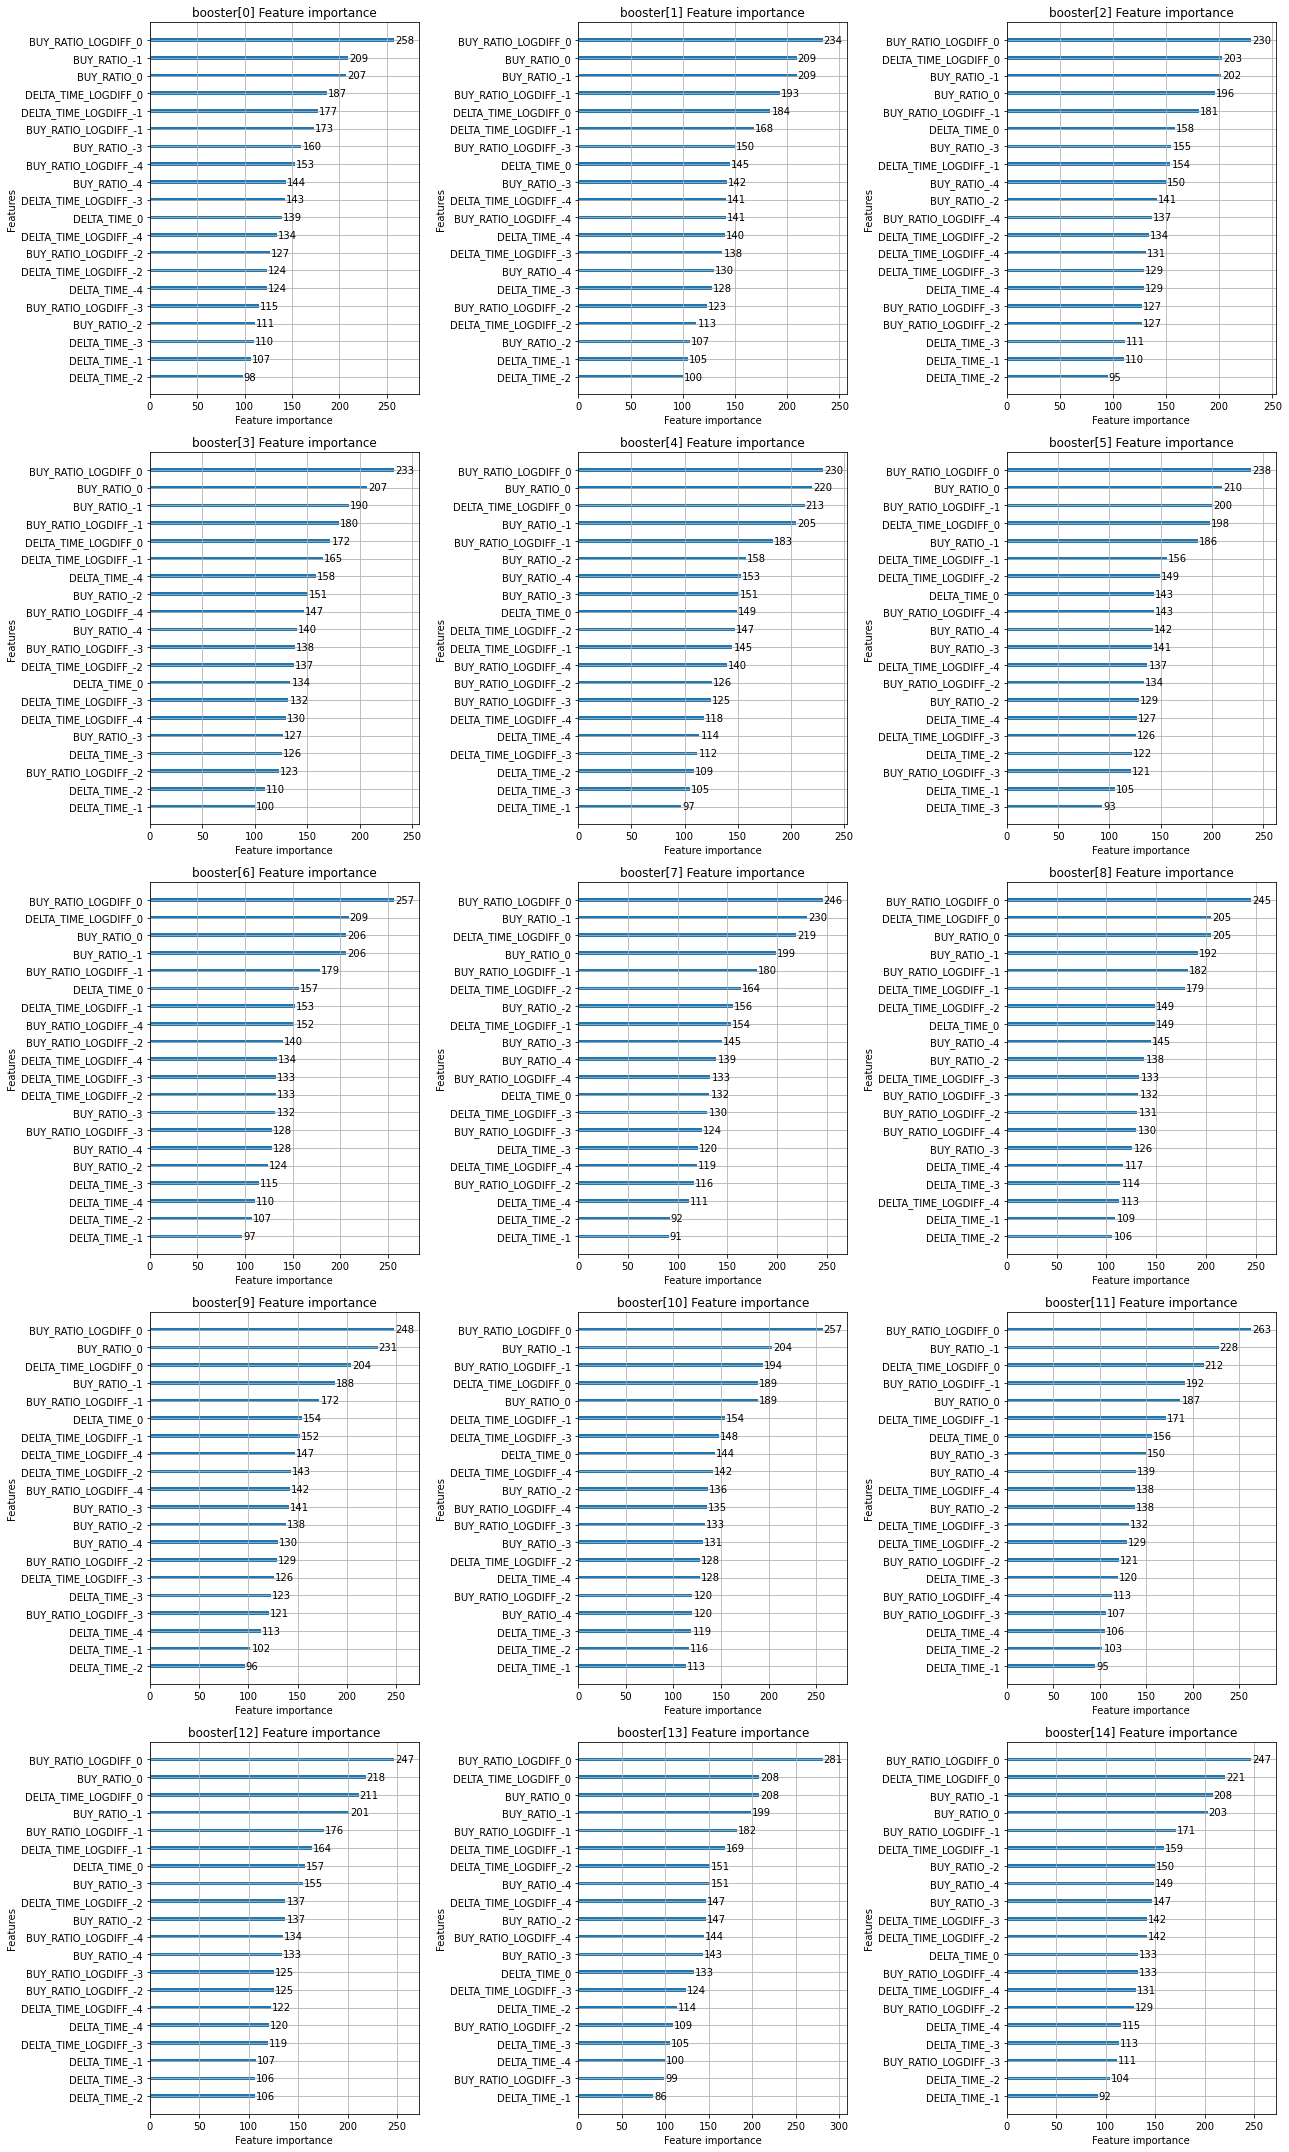

In [11]:
# CPCVによって生成されたbooster全ての特徴量の重要度を表示する
boosters = lgb_util.get_cvbooster().boosters
cols = 3
rows = math.ceil(len(boosters) / cols)
fig, axes = plt.subplots(rows, cols, figsize = (cols * 6, rows * 6), tight_layout=True)

for index, booster in enumerate(boosters):
    lgb.plot_importance(booster, axes[math.floor(index / cols), index % cols], title = f'booster[{index}] Feature importance')

In [12]:
# dtreevizを利用した決定木の可視化
if options['svg_output'] == True:
    light_dtree_reg = ShadowLightGBMTree(lgb_util.get_cvbooster().boosters[0], tree_index = 1, x_data=df_test[features], y_data=df_test['DELTA_TIME'], feature_names=features, target_name='DELTA_TIME')
    viz = trees.dtreeviz(light_dtree_reg, show_node_labels = True, precision = 6)
    viz.save('./lgb_tree.svg')
    print(f'SVG saved.')